In [498]:
# GENERAL IMPORTS TO DEAL WITH DATA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

# STRING MANIPULATION
import string 
import re 

# LIBRARIES FOR CLASSIC NLP 
import nltk 
from nltk.corpus import stopwords 
from nltk.stem.snowball import FrenchStemmer 
from nltk import FreqDist
from nltk.tokenize import word_tokenize
import spacy
import fr_core_news_md

# IMPORTS FOR PARALLEL PROCESSING
import multiprocessing
from functools import partial

# FOR WORDCLOUD
from os import path
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

# FOR MACHINE LEARNING
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report 

# TO DEAL WITH SPARSE MATRIX
from scipy.sparse import hstack

# FOR OVER-SAMPLING TECHNIQUES
from imblearn.over_sampling import SMOTE

# IMPORTING LIGHT GRADIENT BOOSTING
from lightgbm import LGBMClassifier

sns.set_palette(sns.color_palette())
%matplotlib inline

In [2]:
# Loading raw data into a Dataframe
raw_df = pd.read_excel('Ticketing.xlsx')

**<font color='red'>After dataset investigation in another notebook I will discuss each problem and it's solution.</font>**

# -Sort out the most used keywords:

>Feature of interest is Incident-Subject

### Text Preprocessing:


In [188]:
def preprocess(df, column, stemmer = False, lemma = False, stopword= True, digits = True):
    '''
    Takes a df and specific column of texts 
    to return a cleaned and preprocessed dataframe
    
    key arguments:
    df      -- pandas.DataFrame object
    column  -- column name of type string
    '''
    #copy dataframe 
    output_df = df.copy()
    
    #Convert to lowercase
    output_df[column] = output_df[column].apply(lambda text: text.lower())
    
    # General Cleaning
    output_df[column] = output_df[column].apply(lambda text: text.replace('\xa0'," ")) # replace encoded space
    output_df[column] = output_df[column].apply(lambda text: re.sub('<[^>]*>',"", text)) # remove any tags
    output_df[column] = output_df[column].apply(lambda text:
                                            re.sub('(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)'
                                            ," ",text)) # remove any URL
    output_df[column] = output_df[column].apply(lambda text: re.sub(':[^\s]*',"", text))# remove any desk location
    
    # text split or tokenize
    output_df[column] = output_df[column].apply(lambda text: text.split())
    
    output_df[column] = output_df[column].apply(lambda text: [word for word in text if "\\" not in word]) # further remove dir
    output_df[column] = output_df[column].apply(lambda text: [word for word in text if "@" not in word]) # remove E-mails

    if lemma == True: # lemmatization code
        # loading spacy french module to lemmatize
        nlp = fr_core_news_md.load(disable=["tagger", "parser",'ner'])
        output_df[column] = output_df[column].apply(lambda text: [word.lemma_ for word in nlp(text)]) # applying lemma 
    
    if stemmer == True: # stemming code
        #stemming with french stemming object in the FrenchStemmer class
        stemmer = FrenchStemmer() 
        output_df[column] = output_df[column].apply(lambda text: [stemmer.stem(word) for word in text])
        
    # get the number of words in each text
    # output_df['num_words'] = output_df[column].apply(lambda text: len(re.split(r"(?:\s+)|(?:,)|(?:\-)",text)))  
        
    # join words back to a text    
    output_df[column] = output_df[column].apply(lambda text: " ".join([word for word in text]))
    
    #remove special characters and digits
    #output_df[column] = output_df[column].apply(lambda text: re.sub("(\\d|\\W)+"," ",text))
    
    # remove any digit or special character
    clean = string.punctuation
    
    if digits == True:
        clean += string.digits
        
    for c in clean:
        output_df[column] = output_df[column].apply(lambda text: text.replace(c,""))
    
    # Stop word removal
    if stopwords == True:
        stop_words = stopwords.words('french')
        stop_words.extend(stopwords.words('english'))
        stop_words.extend(['a','bonjour', 'cordialement'])
        output_df[column] = output_df[column].apply(lambda text: " ".join([word for word in text.split() if word not in stop_words]))
    
    return output_df

In [4]:
def parallel_process(raw_df, column, NUM_CORES):
    # split the raw dataframe into chunks
    df_chunks = np.array_split(raw_df ,NUM_CORES)

    # use a pool to spawn multiple proecsses
    with multiprocessing.Pool(NUM_CORES) as pool:
    
        # concatenate all processed chunks together.
        # preprocess is the function I defined in the previous block
        output_df = pd.concat(pool.map(partial(preprocess, column=column), df_chunks), ignore_index=True)
        
    return output_df

In [ ]:
df = parallel_process(raw_df, 'Incident-Subject', 8)

Checking preprocessing step

In [6]:
def check(column, check_list):

    processed_tickets = ''
    raw_tickets = ''
    for index in check_list:
        processed_tickets += df[column][index] + 2*'\n'
        raw_tickets += raw_df[column][index] + 2*'\n'
        
    print('--> Clean tickets:\n'+ processed_tickets + 20*'-' + '\n-->Raw tickets:\n' + raw_tickets)

In [7]:
check('Incident-Subject', [60000, 5000, 0])

clean tickets:
origine message mcafee management center alert system alert raised severity message bug bad rsscounter state mm idx val sender esbafwsingle node alert message sent mcafee management center

merci restaurer fichier suivant serveur chemin fichier date restauration restaurer sousdossier restauration dossier original ps faut peutêtre remonter dernière sauvegarde complète si fichier na modifié depuis

bonsoir outil supervision remonté lalerte suivante client serveur frdaplanif adresse ip service service smaopconminosservice note serveur windows retour check smaopconminosservice stopped adil

--------------------
raw tickets:
 Origine: mcafee@poclain-hydraulics.com - 2019-08-22 13:20  Message: McAfee Management Center alert "System alert" was raised at 2019-08-22 13:20:25.   Severity: 0 Message:  [13369471.159776] BUG: Bad rss-counter state mm:ffff880051304f00 idx:0 val:1 Sender: ESBA-FW-Single node 1  This is an alert message sent by McAfee Management Center.   

 Bonjour,  M

In [9]:
# save to file
#df.to_excel('processed.xlsx',index=False)

### Word frequency

In [8]:
#Most frequently occuring words function
def get_top_words(corpus):
    '''
    Takes iterable object of strings and returns a dataframe of top words frequencies
    
    key arguments:
    corpus  -- iterable object of type string
    n       -- int number of top word
    '''
    vec = CountVectorizer().fit(corpus) # fit bag of words to corpus
    bag_of_words = vec.transform(corpus) # Transform to parse matrix of emails x bag of words
    sum_words = bag_of_words.sum(axis=0) # Sum frequencies for each word in all emails
    
    words_freq = [(word, sum_words[0, freq]) for word, freq in vec.vocabulary_.items()] # list of tuples(word, freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) # sort by count
    
    return words_freq

In [9]:
top_words = get_top_words(df['Incident-Subject'])

Text(0, 0.5, 'Frequency\n')

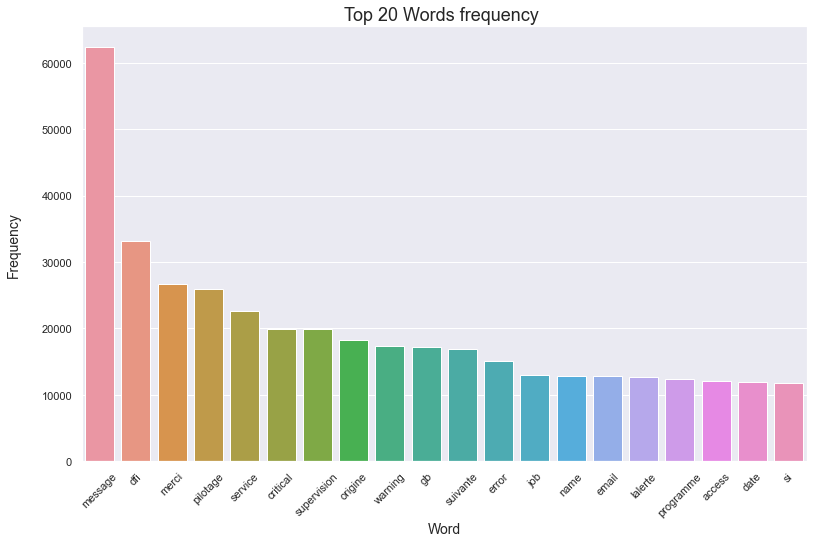

In [10]:
#Convert most freq words to dataframe for plotting bar plot
n = 20
top_df = pd.DataFrame(top_words[0:n])
top_df.columns=["Word", "Frequency"]

#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)});
fig = sns.barplot(x="Word", y="Frequency", data=top_df);
fig.set_xticklabels(fig.get_xticklabels(), rotation=45);
fig.set_title('Top {} Words frequency '.format(n), size = 18);
fig.set_xlabel("Word",fontsize=14)
fig.set_ylabel("Frequency\n",fontsize=14)

**Top 20 word after removing stop words including 'bonjour', 'cordialement'**

### Word cloud:

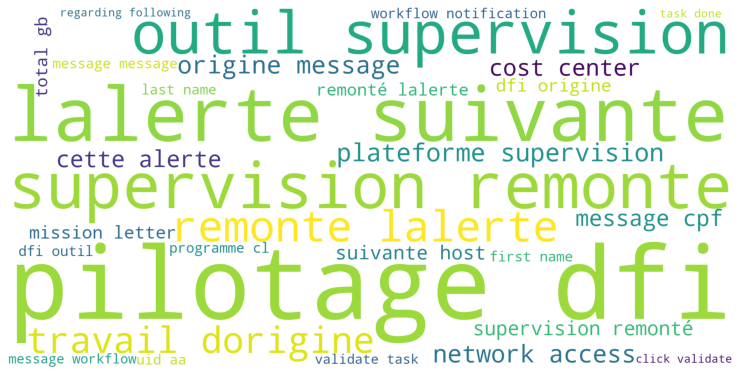

In [11]:
#Word cloud
wordcloud = WordCloud(
                          background_color='white',
                          height=1000,
                          width=2000,
                          max_words=30,
                          max_font_size=300, 
                          random_state=2
                         ).generate(" ".join(df['Incident-Subject']))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Word cloud by its frequency calculation

# -Classify tickets by category:

First of, I will start by classifying only upon ticket body

In [24]:
data1 = df.dropna(subset=['Category'])

In [127]:
data1['Category'].str.lower().nunique()

142

In [241]:
X = data1['Incident-Subject']
y = data1['Category'].str.lower()

In [242]:
y = LabelEncoder().fit_transform(y)

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 26)

In [247]:
pipe = Pipeline([('count', CountVectorizer(ngram_range=(1, 3))),
                      ('tfid', TfidfTransformer())]).fit(X_train)

X_train, X_test = pipe.transform(X_train), pipe.transform(X_test)

In [436]:
# fitting and evaluating function
def fit_evaluate(cl, parameters,X_train=X_train,y_train=y_train):
    """
    this functions takes a classifier and its parameters to fit 
    a gridsearch, predict target values and evaluate the model
    
    Key Arguments:
    cl         -- classifier instantiation 
    parameters -- classifier parameters
    """
    if parameters == None:
        
        # Fit to the training set
        cl.fit(X_train, y_train)
        
        # Predict the labels of the test set: y_pred
        y_pred = cl.predict(X_test)
    else:
        # instantiate grid search with specified parameters
        cv = GridSearchCV(cl, parameters, n_jobs=-1)
    
        # Fit to the training set
        cv.fit(X_train, y_train)

        # Predict the labels of the test set: y_pred
        y_pred = cv.predict(X_test)

    # Compute and print metrics
    if parameters != None:
        print("Accuracy: {} ".format(cv.score(X_test, y_test)))
        print('-' * 20)
        print('classification report:\n\n{}'.format(classification_report(y_test, y_pred)))
        print('-' * 20)
        print("Tuned Model Parameters: {}".format(cv.best_params_))
    else:
        print("Accuracy: {} ".format(cl.score(X_test, y_test)))
        print('-' * 20)
        print('classification report:\n\n{}'.format(classification_report(y_test, y_pred)))
        print('-' * 20)

In [249]:
clf1 = MultinomialNB()
parameters = None
fit_evaluate(clf1,parameters)

Accuracy: 0.6550162563864376 
--------------------
classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.79      0.04      0.08       345
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        76
           7       0.00      0.00      0.00        38
           8       0.00      0.00      0.00        18
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00        31
          11       0.00      0.00      0.00        18
          12       0.00      0.00      0.00        48
          13       0.00      0.00      0.00         2
          14       0.85      0.59      0.70       385
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         6
      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [251]:
clf2 = LGBMClassifier(n_jobs =-1, learning_rate=0.05, random_state=26, n_estimators=10, num_leaves=120)
fit_evaluate(clf2,parameters)

Accuracy: 0.6142011147236415 
--------------------
classification report:

              precision    recall  f1-score   support

           0       0.07      0.29      0.11         7
           1       0.61      0.18      0.28       345
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.05      0.33      0.08         3
           5       0.00      0.00      0.00        17
           6       0.89      0.62      0.73        76
           7       0.60      0.63      0.62        38
           8       0.47      0.89      0.62        18
           9       0.00      0.00      0.00         4
          10       0.36      0.52      0.43        31
          11       0.00      0.00      0.00        18
          12       0.39      0.23      0.29        48
          13       0.00      0.00      0.00         2
          14       0.68      0.44      0.54       385
          15       0.00      0.00      0.00         0
      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


**Category data is really missy and needs a lot of cleaning**

In [128]:
data2 = preprocess(data1,'Category',digits=False,stopwords=False)

In [130]:
np.sort(data2['Category'].unique())

array(['accès applications', 'active directory', 'ad', 'alerte asp',
       'alerte cpu', 'alerte espace disque', 'alerte mémoire',
       'alerte mémoire physique', 'alertes rtms', 'analyse  contrôle',
       'applicatif', 'applicatifs', 'application', 'archivage', 'as400',
       'as400 system  système as400  bt400', 'asp', 'automator', 'autre',
       'autres', 'back up box', 'backup', 'backup  sauvegarde',
       'backup box', 'bandothèque', 'charge cpu', 'citrix',
       'communication', 'compte vpn', 'comptes users',
       'comptes utilisateurs', 'contrôle', 'contrôles',
       'création de boite darchives', 'création de profil notes',
       'création de vm', 'création profil as400',
       'création profil talentia', 'debian', 'demande de prestation',
       'demande dinformation', 'demande projet lotus', 'disk space',
       'documentation', 'données pas à jour', 'downtime',
       'droits  habilitations', 'duplication', 'détection',
       'espace disque', 'esx  vmware', 'ev

In [131]:
data2['Category'].replace(['performance  performance'], 'performance', inplace=True)
data2['Category'].replace(['réseaux','network  réseau','réseau', 'reseau'], 'network', inplace=True)
data2['Category'].replace(['incident de sécurité','security  sécurité','sécurité','securite'], 'security', inplace=True)
data2['Category'].replace(['back up box','backup  sauvegarde','backup box','sauvegarde',
                           'sauvegardes', 'sauvegarde  x86', 'sauvegarde  as400'], 'backup', inplace=True)

data2['Category'].replace(['other', 'other  autres','autres'], 'autre', inplace=True)
data2['Category'].replace(['restauration de fichier', 'restauration de fichiers','restaurations'], 'restauration', inplace=True)
data2['Category'].replace(['applicatif', 'applicatifs'], 'application', inplace=True)

In [132]:
data2['Category'].replace(['contrôles'], 'contrôle', inplace=True)
data2['Category'].replace(['mises à jour'],'mise à jour', inplace=True) 
data2['Category'].replace(['service cbvalmapec', 'service down', 'services arrêtés'],'service down', inplace=True)
data2['Category'].replace(['storage  stockage'],'stockage', inplace=True) 

In [180]:
%%time
data2['Category'].nunique()

Wall time: 6 ms


109

**Now lets try neive bayes classifier after cleaning labels**

In [146]:
X2 = data2['Incident-Subject']
y2 = data2['Category'].str.lower()

In [148]:
y2 = LabelEncoder().fit_transform(y2)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.3, random_state = 26)

In [150]:
pipe = Pipeline([('count', CountVectorizer(ngram_range=(1, 3))),
                      ('tfid', TfidfTransformer())]).fit(X_train)

X_train, X_test = pipe.transform(X_train), pipe.transform(X_test)

In [183]:
%%time
clf1 = MultinomialNB()
parameters = None
fit_evaluate(clf1,parameters)

Accuracy: 0.6740013934045518 
--------------------
classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.79      0.04      0.08       345
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        76
           7       0.00      0.00      0.00        38
           8       0.00      0.00      0.00        18
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00        97
          11       0.00      0.00      0.00         2
          12       0.88      0.53      0.66       385
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         6
          16       0.44      0.80      0.57      3191
          17       0.82      0.73      0.78      1386
      

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Now I will clean Ticket Title to merge it with Ticket body and add auther**

In [259]:
data3 = preprocess(data2,column='Ticket Title')

In [260]:
# adding title with double weight as it should give better explanation for the problem

X3 = data3['Incident-Subject']  + " " + 2*data3['Ticket Title']
y3 = data3['Category']

In [261]:
pipe = Pipeline([('count', CountVectorizer(ngram_range=(1, 3))),
                      ('tfid', TfidfTransformer())]).fit(X3)

In [270]:
my_X = pipe.transform(X3)
my_X

<57412x1206795 sparse matrix of type '<class 'numpy.float64'>'
	with 5864987 stored elements in Compressed Sparse Row format>

In [269]:
# transform 'Author' to one-hot-encoding of sparse matrix.
author = OneHotEncoder().fit_transform(data3['Author'].str.lower().to_numpy().reshape(-1, 1))
author

<57412x360 sparse matrix of type '<class 'numpy.float64'>'
	with 57412 stored elements in Compressed Sparse Row format>

In [275]:
# concatenate training data sparse matrix with 'Auther' sparse matrix.
X3 = hstack((my_X,author))
X3

<57412x1207155 sparse matrix of type '<class 'numpy.float64'>'
	with 5922399 stored elements in COOrdinate format>

In [276]:
y3 = LabelEncoder().fit_transform(y3)

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size = 0.3, random_state = 26)

In [278]:
%%time
clf1 = MultinomialNB()
parameters = None
fit_evaluate(clf1,parameters)

Accuracy: 0.7159777055271714 
--------------------
classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00       345
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        17
           6       1.00      0.78      0.87        76
           7       0.00      0.00      0.00        38
           8       0.00      0.00      0.00        18
           9       0.00      0.00      0.00         4
          10       1.00      0.12      0.22        97
          11       0.00      0.00      0.00         2
          12       0.86      0.65      0.74       385
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         6
          16       0.48      0.83      0.61      3191
          17       0.78      0.78      0.78      1386
      

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now train on LGBM

In [285]:
%%time
clf2 = LGBMClassifier(n_jobs =-1, learning_rate=0.05, random_state=26, n_estimators=10, num_leaves=150)
fit_evaluate(clf2,parameters)

Accuracy: 0.7083139804923363 
--------------------
classification report:

              precision    recall  f1-score   support

           0       0.05      0.43      0.09         7
           1       0.65      0.29      0.40       345
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.17      1.00      0.29         3
           5       0.80      0.94      0.86        17
           6       0.94      0.88      0.91        76
           7       0.50      0.63      0.56        38
           8       0.29      0.67      0.40        18
           9       0.04      0.25      0.07         4
          10       0.46      0.42      0.44        97
          11       0.00      0.00      0.00         2
          12       0.90      0.65      0.76       385
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         6
      

In [286]:
%%time
clf3 = LGBMClassifier(n_jobs =-1, learning_rate=0.05, random_state=26, n_estimators=20, num_leaves=120)
fit_evaluate(clf3,parameters)

Accuracy: 0.6123432419879238 
--------------------
classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.61      0.28      0.38       345
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.14      1.00      0.25         3
           5       0.88      0.41      0.56        17
           6       0.81      0.88      0.84        76
           7       0.68      0.68      0.68        38
           8       0.21      0.78      0.33        18
           9       0.00      0.00      0.00         4
          10       0.53      0.38      0.44        97
          11       0.00      0.00      0.00         2
          12       0.71      0.50      0.59       385
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         6
      

In [288]:
%%time
clf4 = LGBMClassifier(n_jobs =-1, learning_rate=0.03, random_state=26, n_estimators=10, num_leaves=200)
fit_evaluate(clf4,parameters)
#best params

Accuracy: 0.7518578727357176 
--------------------
classification report:

              precision    recall  f1-score   support

           0       0.06      0.29      0.10         7
           1       0.65      0.26      0.37       345
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.21      1.00      0.35         3
           5       0.94      0.94      0.94        17
           6       0.96      0.96      0.96        76
           7       0.84      0.82      0.83        38
           8       0.50      0.89      0.64        18
           9       0.00      0.00      0.00         4
          10       0.82      0.33      0.47        97
          11       0.00      0.00      0.00         2
          12       0.91      0.73      0.81       385
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         6
      

In [291]:
%%time
clf5 = LGBMClassifier(n_jobs =-1, learning_rate=0.03, random_state=26, n_estimators=10, num_leaves=300)
fit_evaluate(clf5,parameters)
# 2nd best params

Accuracy: 0.7497097073850442 
--------------------
classification report:

              precision    recall  f1-score   support

           0       0.06      0.29      0.10         7
           1       0.66      0.28      0.39       345
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.21      1.00      0.35         3
           5       0.94      0.94      0.94        17
           6       0.96      0.96      0.96        76
           7       0.89      0.82      0.85        38
           8       0.50      0.89      0.64        18
           9       0.00      0.00      0.00         4
          10       0.79      0.31      0.44        97
          11       0.00      0.00      0.00         2
          12       0.91      0.72      0.81       385
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         6
      

In [307]:
%%time
clf_best = LGBMClassifier(n_jobs =-1, learning_rate=0.03, random_state=26, n_estimators=10, num_leaves=200)
fit_evaluate(clf_best,parameters)
#best params

Accuracy: 0.7481421272642824 
--------------------
classification report:

              precision    recall  f1-score   support

           0       0.07      0.29      0.11         7
           1       0.68      0.27      0.38       345
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.21      1.00      0.35         3
           5       0.94      0.94      0.94        17
           6       0.96      0.96      0.96        76
           7       0.82      0.82      0.82        38
           8       0.50      0.89      0.64        18
           9       0.00      0.00      0.00         4
          10       0.82      0.32      0.46        97
          11       0.00      0.00      0.00         2
          12       0.91      0.71      0.80       385
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         6
      

In [334]:
# saving model for further use

from joblib import dump

dump(clf_best, 'tickets_category_LGBM.joblib') 

['tickets_category_LGBM.joblib']

# -Classify tickets by type:

In [337]:
Type_df = df[['Incident-Subject','Type']].copy()

In [341]:
Type_df.Type.value_counts()

Incidents      48952
Demandes       39900
Changements      206
Name: Type, dtype: int64

In [350]:
Type_df[Type_df['Type'] == 'Changements']['Incident-Subject'].iloc[2]

'serveur cognacx pouvez supprimer disk numéro merci davance jm mahe'

In [352]:
X_type = df['Incident-Subject']
y_type = Type_df['Type']

In [353]:
pipe = Pipeline([('count', CountVectorizer(ngram_range=(1, 3))),
                      ('tfid', TfidfTransformer())]).fit(X_type)

In [354]:
my_X = pipe.transform(X_type)
my_X

<89058x1546392 sparse matrix of type '<class 'numpy.float64'>'
	with 7713574 stored elements in Compressed Sparse Row format>

In [373]:
my_y = LabelEncoder().fit_transform(y_type)
my_y

array([2, 2, 2, ..., 2, 2, 2])

In [437]:
X_train, X_test, y_train, y_test = train_test_split(my_X, my_y, test_size = 0.3, random_state = 26, stratify=my_y )

In [438]:
#over sampling training data
smote = SMOTE(n_jobs=-1, random_state=26)

In [439]:
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [440]:
np.unique(y_train,return_counts=True)

(array([0, 1, 2]), array([  144, 27930, 34266], dtype=int64))

In [444]:
%%time
#without resampling
type_clf1 = MultinomialNB()
parameters = None
fit_evaluate(type_clf1,parameters,X_train,y_train)

Accuracy: 0.9189684856650947 
--------------------
classification report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.87      0.96      0.91     11970
           2       0.97      0.89      0.93     14686

    accuracy                           0.92     26718
   macro avg       0.61      0.62      0.61     26718
weighted avg       0.92      0.92      0.92     26718

--------------------
Wall time: 341 ms


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [445]:
%%time
#with resampling
type_clf2 = MultinomialNB()
parameters = None
fit_evaluate(type_clf2,parameters,X_train_res,y_train_res)
#better

Accuracy: 0.9062804102103451 
--------------------
classification report:

              precision    recall  f1-score   support

           0       0.11      0.74      0.19        62
           1       0.86      0.95      0.90     11970
           2       0.98      0.87      0.92     14686

    accuracy                           0.91     26718
   macro avg       0.65      0.85      0.67     26718
weighted avg       0.92      0.91      0.91     26718

--------------------
Wall time: 369 ms


with resampling the naive bayes model gets better score in precision and recall

**Now lets try Light gradient boosting**

In [454]:
%%time
#without resampling, as LGBM is based on a resampling bootstrapping technique already
type_clf3 = LGBMClassifier(n_jobs =-1, learning_rate=0.03, random_state=26, n_estimators=100, num_leaves=200)
parameters = None
fit_evaluate(type_clf3,parameters,X_train,y_train)

Accuracy: 0.9348753649225241 
--------------------
classification report:

              precision    recall  f1-score   support

           0       0.93      0.45      0.61        62
           1       0.91      0.95      0.93     11970
           2       0.96      0.93      0.94     14686

    accuracy                           0.93     26718
   macro avg       0.93      0.78      0.83     26718
weighted avg       0.94      0.93      0.93     26718

--------------------
Wall time: 4min 14s


In [455]:
%%time
#without resampling, as LGBM is based on a resampling bootstrapping technique already
type_clf3 = LGBMClassifier(n_jobs =-1, learning_rate=0.03, random_state=26, n_estimators=200, num_leaves=100)
parameters = None
fit_evaluate(type_clf3,parameters,X_train,y_train)

Accuracy: 0.9364847668238641 
--------------------
classification report:

              precision    recall  f1-score   support

           0       0.90      0.45      0.60        62
           1       0.91      0.95      0.93     11970
           2       0.96      0.93      0.94     14686

    accuracy                           0.94     26718
   macro avg       0.92      0.78      0.83     26718
weighted avg       0.94      0.94      0.94     26718

--------------------
Wall time: 5min 14s


In [456]:
%%time
#without resampling, as LGBM is based on a resampling bootstrapping technique already
type_clf3 = LGBMClassifier(n_jobs =-1, learning_rate=0.03, random_state=26, n_estimators=160, num_leaves=160)
parameters = None
fit_evaluate(type_clf3,parameters,X_train,y_train)

Accuracy: 0.9375327494572947 
--------------------
classification report:

              precision    recall  f1-score   support

           0       0.91      0.47      0.62        62
           1       0.91      0.95      0.93     11970
           2       0.96      0.93      0.94     14686

    accuracy                           0.94     26718
   macro avg       0.93      0.78      0.83     26718
weighted avg       0.94      0.94      0.94     26718

--------------------
Wall time: 5min 45s


**Now train best params on all of the dataset**

In [ ]:
#without resampling, as LGBM is based on a resampling bootstrapping technique already
type_best_clf = LGBMClassifier(n_jobs =-1, learning_rate=0.03, random_state=26, n_estimators=160, num_leaves=160)
type_best_clf.fit(my_X,my_y)

In [ ]:
# saving model for further use
dump(clf_best, 'tickets_type_LGBM.joblib') 